## Diabetes Diagnosis

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
np.random.seed(1)

In [6]:
# load data
s = pd.read_csv('../diabetes_data.csv',sep= ',', header= None)
s.head()

,0,1,2,3,4,5,6,7,8
0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0


The data contains 8 features:<br/>
1) Pregnancies: Number of times pregnant<br/>
2) Glucose: Plasma glucose concentration at 2 hours in an oral glucose tolerance test (GTT)<br/>
3) BloodPressure: Diastolic blood pressure (mmHg)<br/>
4) SkinThickness: Triceps skin fold thickness (mm)<br/>
5) Insulin: 2-Hour serum insulin (mu U/ml)<br/>
6) BMI: Body Mass Index (weight(kg)/(height(m))^2)<br/>
7) DiabetesPedigreeFunction: Diabetes Pedigree Function<br/>
8) Age: Age (years)<br/>

and 1 target: 1 (positive), 0 (negative)

### Impute missing data

In [7]:
# impute missing data
Xy = np.loadtxt('../diabetes_data_imputed_knn3.txt').astype(float)

# select features and target:
X = Xy[:,:8]
y = Xy[:,8]

# convert 1,0 to 1,-1:
y = 2*y - 1

In [8]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

### Prediction

In [9]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.01)
        y_pred = ER.predict(X_test,h0,w)
        y_pred_train = ER.predict(X_train,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [10]:
list_methods=['logistic_regression','naive_bayes','random_forest','decision_tree','expectation_reflection']
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        #idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y_train0)),replace=False)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1)

In [11]:
def plot_accuracy():
    plt.figure(figsize=(4,3))    
    plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
    plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
    plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
    #plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
    plt.plot(list_train_size,acc[:,4],'k-',marker='o',label='Expectation Reflection')
    plt.xlabel('train size')
    plt.ylabel('accuracy')
    plt.legend()

In [12]:
list_train_size = [0.8,0.6,0.4,0.2,0.1]
acc = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.76714286 0.74831169 0.76012987 0.70993506 0.76993506]
0.6 [0.76837662 0.75149351 0.76090909 0.69811688 0.77045455]
0.4 [0.75662338 0.7462987  0.75058442 0.68948052 0.76019481]
0.2 [0.74097403 0.74168831 0.74857143 0.68168831 0.75857143]
0.1 [0.71402597 0.745      0.73668831 0.67305195 0.75448052]


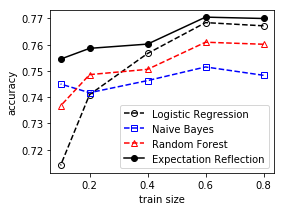

In [13]:
plot_accuracy()